In [2]:
# Download, and load the Fashion NMIST dataset
import torch
from torchvision import datasets, transforms

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,)),])

# download and load the MNISt trainset
trainset = datasets.FashionMNIST("C:/Users/arman/Desktop/F_MNIST",download= True, train= True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle= True)

# download and load the MNISt testset 
testset = datasets.FashionMNIST("C:/Users/arman/Desktop/F_MNIST", download= True, train= False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size= 32, shuffle= True)


In [6]:
# Tensors  
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.shape)
print(labels.shape)
print(type(images))

torch.Size([32, 1, 28, 28])
torch.Size([32])
<class 'torch.Tensor'>


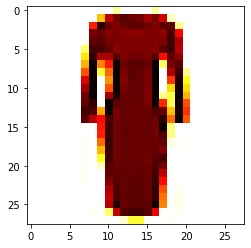

In [7]:
# Visualize some input data

import matplotlib.pyplot as plt 
import numpy as np 

plt.imshow(images[1].numpy().squeeze(), cmap="hot_r")

In [8]:
# Define our network architecture

from torch import nn, optim
import torch.nn.functional as F

class FmnistClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 10)

        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        # input tensor flattened
        x = x.view(x.shape[0], -1)

        # Now with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.dropout(F.relu(self.fc4(x)))

        # output so no dropout here
        x = F.log_softmax(self.fc5(x), dim=1)

        return x

model = FmnistClassifier()
model

FmnistClassifier(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=32, bias=True)
  (fc5): Linear(in_features=32, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [9]:
# Model Training

model = FmnistClassifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 10
steps = 0

train_losses, test_losses = [], []

for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        optimizer.zero_grad()
        log_ps =model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    else:

        test_loss = 0
        accuracy = 0 

        with torch.no_grad():
            model.eval()
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                ps = torch.exp(log_ps)

                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))

        model.train()
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))


        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Test Loss: {:.3f}.. ".format(test_losses[-1]),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/10..  Training Loss: 0.667..  Test Loss: 0.489..  Test Accuracy: 0.822
Epoch: 2/10..  Training Loss: 0.482..  Test Loss: 0.413..  Test Accuracy: 0.849
Epoch: 3/10..  Training Loss: 0.439..  Test Loss: 0.412..  Test Accuracy: 0.852
Epoch: 4/10..  Training Loss: 0.416..  Test Loss: 0.381..  Test Accuracy: 0.863
Epoch: 5/10..  Training Loss: 0.396..  Test Loss: 0.380..  Test Accuracy: 0.864
Epoch: 6/10..  Training Loss: 0.383..  Test Loss: 0.370..  Test Accuracy: 0.868
Epoch: 7/10..  Training Loss: 0.370..  Test Loss: 0.364..  Test Accuracy: 0.871
Epoch: 8/10..  Training Loss: 0.361..  Test Loss: 0.368..  Test Accuracy: 0.867
Epoch: 9/10..  Training Loss: 0.351..  Test Loss: 0.370..  Test Accuracy: 0.872
Epoch: 10/10..  Training Loss: 0.345..  Test Loss: 0.362..  Test Accuracy: 0.867


In [10]:
# Save our model
torch.save(model.state_dict(), "F_MNISTcheckpoint.pth")

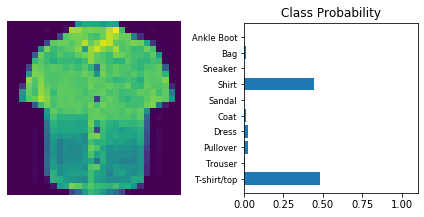

In [19]:
# Test out your network!
import draw

model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
# Convert 2D image to 1D vector
img = img.view(1, 784)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)

# Plot the image and probabilities
draw.view_classification(img.view(1, 28, 28), ps, version='Fashion')

In [12]:
# Calculate the total accuracy 

correct_count, all_count = 0, 0

for images,labels in testloader:
  for i in range(len(labels)):
    img = images[i].view(1, 784)
    with torch.no_grad():
        logps = model(img)

    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000

Model Accuracy = 0.8667
